In [1]:
import sys
sys.path.append('.')

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import sklearn
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import FunctionTransformer as FT

from lib.Extractor import FeatureExtractor
from lib.Models import FullyConnectedNetworkClassifier
from lib.Datasets import TabularDataset
from lib.Transformers import NumericalTransformer, CategoricalTransformer, DatasetTransformer

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader

In [2]:
print(sklearn.__version__), print(np.__version__)

0.23.2
1.19.1


(None, None)

##### Reproducibility

In [3]:
torch.manual_seed(0)
np.random.seed(0)

### Whole training set

In [4]:
whole_train_df = pd.read_csv('train.csv.gz', compression='gzip', header=0, sep=',', error_bad_lines=False, low_memory=False)
print('{0:,} registros a las {1}'.format(len(whole_train_df), datetime.now()))
whole_train_df.head()

180,761 registros a las 2020-09-10 10:49:17.327969


,accepts_mercadopago,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,boosted,...,total_orders_sel_30days,total_si_domain_30days,total_si_item_30days,total_si_sel_30days,total_visits_domain,total_visits_item,total_visits_seller,uid,user_id,warranty
0,True,59,938.031376,2153.933091,135195.200333,3.430563,12.407860,13.691450,0.001,False,...,23364.0,56717.0,17.0,25781.0,7993972,543,854813,cb5bfac7-229a-4e3e-96dd-80b2ad3972c1,NaN,Garantía de fábrica: 12 meses
1,True,37,159.826531,240.325973,19338.230000,3.142739,4.429577,4.511599,0.001,False,...,10693.0,81455.0,5.0,10891.0,7821316,1789,1422288,b0f9aa19-00d5-4afd-aa77-45be7c849562,NaN,NaN
2,True,9,67.635391,86.066296,154.919333,2.633771,2.592593,2.722222,0.001,False,...,140.0,16792.0,8.0,147.0,1303909,1473,17801,fd59890a-f2c2-4282-b2ee-c68f25e20697,151157147.0,NaN
3,True,12,92.085756,332.848400,554.747333,3.280069,12.620000,12.840000,0.001,False,...,631.0,1988.0,14.0,642.0,139419,7473,44336,72340acf-2a1c-4214-a604-132e0cb56939,NaN,Garantía de fábrica: 90 días
4,True,5,156.905222,955.997475,3154.791667,2.737876,3.666667,4.363636,0.001,False,...,363.0,8707.0,32.0,432.0,209373,416,46206,84da1314-814c-4d4f-be23-3de9ea1da4b6,NaN,Garantía del vendedor: 90 días


In [5]:
whole_train_df['conversion'].value_counts()

False    164017
True      16744
Name: conversion, dtype: int64

### Training and Validation set's split

In [6]:
train_data = []
validation_data = []

for row in whole_train_df.itertuples(index=False):
    if abs(hash(row.item_id)) % 10 < 2: 
        validation_data.append(row)
    else:
        train_data.append(row)
        
train_df = pd.DataFrame(data=train_data, columns=whole_train_df.columns)
validation_df = pd.DataFrame(data=validation_data, columns=whole_train_df.columns)

In [7]:
print('{0:,} registros a las {1}'.format(len(train_df), datetime.now()))
train_df.head()

142,721 registros a las 2020-09-10 10:49:21.620401


,accepts_mercadopago,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,boosted,...,total_orders_sel_30days,total_si_domain_30days,total_si_item_30days,total_si_sel_30days,total_visits_domain,total_visits_item,total_visits_seller,uid,user_id,warranty
0,True,59,938.031376,2153.933091,135195.200333,3.430563,12.407860,13.691450,0.001,False,...,23364.0,56717.0,17.0,25781.0,7993972,543,854813,cb5bfac7-229a-4e3e-96dd-80b2ad3972c1,NaN,Garantía de fábrica: 12 meses
1,True,37,159.826531,240.325973,19338.230000,3.142739,4.429577,4.511599,0.001,False,...,10693.0,81455.0,5.0,10891.0,7821316,1789,1422288,b0f9aa19-00d5-4afd-aa77-45be7c849562,NaN,NaN
2,True,9,67.635391,86.066296,154.919333,2.633771,2.592593,2.722222,0.001,False,...,140.0,16792.0,8.0,147.0,1303909,1473,17801,fd59890a-f2c2-4282-b2ee-c68f25e20697,151157147.0,NaN
3,True,12,92.085756,332.848400,554.747333,3.280069,12.620000,12.840000,0.001,False,...,631.0,1988.0,14.0,642.0,139419,7473,44336,72340acf-2a1c-4214-a604-132e0cb56939,NaN,Garantía de fábrica: 90 días
4,True,5,156.905222,955.997475,3154.791667,2.737876,3.666667,4.363636,0.001,False,...,363.0,8707.0,32.0,432.0,209373,416,46206,84da1314-814c-4d4f-be23-3de9ea1da4b6,NaN,Garantía del vendedor: 90 días


In [8]:
print('{0:,} registros a las {1}'.format(len(validation_df), datetime.now()))
validation_df.head()

38,040 registros a las 2020-09-10 10:49:21.645359


,accepts_mercadopago,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,boosted,...,total_orders_sel_30days,total_si_domain_30days,total_si_item_30days,total_si_sel_30days,total_visits_domain,total_visits_item,total_visits_seller,uid,user_id,warranty
0,True,7,224.204346,214.277733,535.694333,4.344064,12.240000,22.973333,0.001,False,...,918.0,2339.0,55.0,1723.0,180386,5132,46381,67b5ca7d-32a2-4415-9594-d0afe6dd1c26,206574359.0,Garantía de fábrica: 30 días
1,True,103,145.135733,210.173802,2192.813333,2.919105,3.913738,3.936102,0.001,False,...,1225.0,62311.0,5.0,1232.0,8771098,175,124650,84657B30-C2C4-4E85-9C5C-56B97F7D8AA2,458914812.0,NaN
2,True,88,542.637015,946.298046,2744.264333,12.550167,5.275862,11.655172,0.001,False,...,459.0,50590.0,13.0,1014.0,1464836,584,52950,776c167c-86ae-439a-a43b-3b2e49e5b28b,183272651.0,Sin garantía
3,True,12070,421.741468,186.159000,372.318000,5.584577,12.850000,16.800000,0.001,False,...,771.0,2364.0,10.0,1008.0,147798,599,46868,34b6f9ee-c6fb-42fc-9b21-cfa428ec986d,NaN,Sin garantía
4,True,159,169.234106,232.164797,22535.463000,3.505991,4.756868,4.916896,0.001,False,...,13852.0,85853.0,78.0,14318.0,13032888,9324,1987466,faad859a-02eb-4275-97b3-b8a148ae93c3,83869460.0,NaN


### Test set

In [9]:
test_df = pd.read_csv('test.csv', sep=',')
print('{0:,} registros a las {1}'.format(len(test_df), datetime.now()))
test_df.head()

19,211 registros a las 2020-09-10 10:49:21.912797


,accepts_mercadopago,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,boosted,...,total_si_domain_30days,total_si_item_30days,total_si_sel_30days,total_visits_domain,total_visits_item,total_visits_seller,uid,user_id,warranty,ROW_ID
0,True,4,98.426510,91.979648,3657.724000,3.589443,3.461023,4.988265,0.001,False,...,1364.0,18.0,5951.0,40954,300,100477,703f4bd1-cc3e-4102-8cfa-fe3cdd15ebb7,233223201.0,Garantia de fabrica,0
1,True,12,242.485208,821.376944,985.652333,3.215580,26.222222,28.388889,0.001,False,...,3724.0,41.0,1022.0,135133,926,44033,d714e65e-5447-4f7d-9a4e-aaa57efa6107,337881137.0,NaN,1
2,True,5,2450.533424,1365.504354,33454.856667,7.097276,14.646259,15.217687,0.001,False,...,1839.0,71.0,11185.0,204788,8457,716157,299cb623-b71c-4f9d-b792-48d5744f0449,86609353.0,Garantía de fábrica: 12 meses,2
3,True,9052,157.735448,78.692131,160.007333,4.927390,2.983607,3.524590,0.001,False,...,85528.0,44.0,215.0,1404477,1907,6580,f2060244-f0da-43db-91b7-4c1bb5f99e67,430797570.0,Sin garantía,3
4,True,37,116.891454,163.245653,4043.050667,2.937837,7.257066,19.771198,0.001,False,...,61466.0,274.0,14690.0,1466424,2633,215184,d7f3b7f4-a9fa-4bd8-a600-3f2714480779,6566243.0,Garantía de fábrica: 6 meses,4


### Selected features

In [10]:
numerical_features = [
    'available_quantity',
    'avg_gmv_item_sel',
    'avg_qty_orders_item_domain_30days',
    'avg_qty_orders_item_sel_30days',
    'health', 
    'sold_quantity',
    'total_asp_item_domain_30days',
    'total_asp_item_sel_30days',
    'total_gmv_domain_bday',
    'total_gmv_item_30days',
    'total_items_seller',
    'total_orders_domain_30days',
    'total_orders_item_30days',
    'total_orders_sel_30days',  
]

categorical_features = [
    'free_shipping',
    'is_pdp',
    
    # Categoricals
    'category_id',
    'deal_print_id',
    'domain_id',
    'product_id',
    'item_id',
    'listing_type_id',
    'logistic_type',
    'platform',
    'tags',
    'uid',
    'user_id',
    'offset',  
    'print_position',
]

date_features = ['date']
new_categorical_features = ['day_of_week', 'is_weekend']
target_column = ['conversion']

In [11]:
len(numerical_features), len(categorical_features), len(date_features), len(numerical_features+categorical_features+new_categorical_features)

(14, 15, 1, 31)

### Dataset's features subsetings

#### Training

In [12]:
X_train = train_df[categorical_features+numerical_features].to_numpy()
Y_train = train_df[target_column].to_numpy()
print('{0:,} registros a las {1}'.format(len(X_train), datetime.now()))
X_train[:3,:], X_train.shape, Y_train[:3,:], Y_train.shape

142,721 registros a las 2020-09-10 10:49:22.094645


(array([[True, False, 'MLA1055', 'a9cb2270-5f61-11ea-89fc-13e674cbfad4',
         'MLA-CELLPHONES', 15183595.0, 'MLA830939055', 'gold_special',
         'cross_docking', '/web/desktop',
         '[good_quality_picture, good_quality_thumbnail, today_promotion, brand_verified, extended_warranty_eligible, immediate_payment, cart_eligible]',
         'cb5bfac7-229a-4e3e-96dd-80b2ad3972c1', nan, 0, 1717, 59,
         2153.933091, 3.4305625, 12.407859798194373, 0.0, 65,
         277.20515880060003, 188.75394947, 500283.400333, 5793.18, 4119,
         54889.0, 17.0, 23364.0],
        [True, False, 'MLA3724', '17bfe7b0-7480-11ea-a387-65bd48ab9972',
         'MLA-SNEAKERS', nan, 'MLA823451186', 'gold_special', 'drop_off',
         '/mobile/android',
         '[good_quality_thumbnail, incomplete_technical_specs, today_promotion, brand_verified, good_quality_picture, immediate_payment, cart_eligible]',
         'b0f9aa19-00d5-4afd-aa77-45be7c849562', nan, 288, 311, 37,
         240.325973, 3.1427

#### Validation

In [13]:
X_validation = validation_df[categorical_features+numerical_features].to_numpy()
Y_valitation = validation_df[target_column].to_numpy()
print('{0:,} registros a las {1}'.format(len(X_validation), datetime.now()))
X_validation[:3,:], X_validation.shape, Y_valitation[:3,:], Y_valitation.shape

38,040 registros a las 2020-09-10 10:49:22.136920


(array([[False, nan, 'MLA11236', 'cc407620-86e9-11ea-9076-139c55b6e72a',
         'MLA-PLAYGROUND_SWING_SETS', nan, 'MLA822540433', 'gold_special',
         'fulfillment', '/mobile/android',
         '[loyalty_discount_eligible, brand_verified, good_quality_picture, good_quality_thumbnail, immediate_payment, cart_eligible]',
         '67b5ca7d-32a2-4415-9594-d0afe6dd1c26', 206574359.0, 144, 206, 7,
         214.277733, 4.344064386317908, 12.24, 0.77, 123, 57.6037147485,
         16.60267056, 3714.318667, 1036.24, 126, 2159.0, 52.0, 918.0],
        [True, False, 'MLA109027', '4b52a5a0-7beb-11ea-a906-9fd3391fb36e',
         'MLA-SNEAKERS', nan, 'MLA823713224', 'gold_special',
         'cross_docking', '/mobile/ios',
         '[brand_verified, good_quality_picture, good_quality_thumbnail, immediate_payment, cart_eligible]',
         '84657B30-C2C4-4E85-9C5C-56B97F7D8AA2', 458914812.0, 96, 7718,
         103, 210.173802, 2.9191046628167805, 3.9137380191693287, 0.66, 6,
         56.18285851

#### Testing

In [14]:
X_test = test_df[categorical_features+numerical_features].to_numpy()
print('{0:,} registros a las {1}'.format(len(X_test), datetime.now()))
X_test[:3,:], X_test.shape

19,211 registros a las 2020-09-10 10:49:22.160871


(array([[False, False, 'MLA29933', '13486cc0-7b38-11ea-80da-b7bc289f1eb3',
         'MLA-HEATING_PADS', nan, 'MLA687322333', 'gold_special',
         'cross_docking', '/mobile/android',
         '[brand_verified, good_quality_picture, loyalty_discount_eligible, immediate_payment, cart_eligible]',
         '703f4bd1-cc3e-4102-8cfa-fe3cdd15ebb7', 233223201.0, 528, 828, 4,
         91.979648, 3.5894428152492672, 3.4610226320201174, 0.66, 41,
         24.540562950100004, 20.3597047167, 1118.781333, 480.73, 2383,
         1224.0, 18.0, 4129.0],
        [True, nan, 'MLA120354', '91f51450-7094-11ea-a195-69da39a3a2bc',
         'MLA-SUITCASES', nan, 'MLA787958329', 'gold_special',
         'fulfillment', '/mobile/android',
         '[good_quality_thumbnail, loyalty_discount_eligible, today_promotion, brand_verified, good_quality_picture, immediate_payment]',
         'd714e65e-5447-4f7d-9a4e-aaa57efa6107', 337881137.0, 432, 470,
         12, 821.3769440000003, 3.215579710144928, 26.22222222222

### Transformations

#### Feature extractions

In [15]:
def decompose_print_date(features:np.ndarray) -> np.ndarray:
    print_date_feature = features[0]
    dates = [datetime.strptime(str_date, '%Y-%m-%d') for str_date in print_date_feature]
    date_parts = np.array([[dt.year, dt.month, dt.day, dt.weekday()+1, 0 if dt.weekday() >= 0 and dt.weekday() <= 4 else 1] for dt in dates], dtype=np.int32)
    return date_parts[:,0], date_parts[:,1], date_parts[:,2], date_parts[:,3], date_parts[:,4]

In [16]:
# Year, Month, Day, Day of the week, Is weekend
print_date_ft_extractor = FeatureExtractor(decompose_print_date)
_, _, _, day_of_week_feature, is_weekend_feature = print_date_ft_extractor.transform([train_df['date'].to_numpy()])
X_train = np.hstack((X_train, day_of_week_feature.reshape(-1,1), is_weekend_feature.reshape(-1,1)))
X_train[:3,:], X_train.shape

(array([[True, False, 'MLA1055', 'a9cb2270-5f61-11ea-89fc-13e674cbfad4',
         'MLA-CELLPHONES', 15183595.0, 'MLA830939055', 'gold_special',
         'cross_docking', '/web/desktop',
         '[good_quality_picture, good_quality_thumbnail, today_promotion, brand_verified, extended_warranty_eligible, immediate_payment, cart_eligible]',
         'cb5bfac7-229a-4e3e-96dd-80b2ad3972c1', nan, 0, 1717, 59,
         2153.933091, 3.4305625, 12.407859798194373, 0.0, 65,
         277.20515880060003, 188.75394947, 500283.400333, 5793.18, 4119,
         54889.0, 17.0, 23364.0, 5, 0],
        [True, False, 'MLA3724', '17bfe7b0-7480-11ea-a387-65bd48ab9972',
         'MLA-SNEAKERS', nan, 'MLA823451186', 'gold_special', 'drop_off',
         '/mobile/android',
         '[good_quality_thumbnail, incomplete_technical_specs, today_promotion, brand_verified, good_quality_picture, immediate_payment, cart_eligible]',
         'b0f9aa19-00d5-4afd-aa77-45be7c849562', nan, 288, 311, 37,
         240.325973, 

In [17]:
_, _, _, day_of_week_feature, is_weekend_feature = print_date_ft_extractor.transform([validation_df['date'].to_numpy()])
X_validation = np.hstack((X_validation, day_of_week_feature.reshape(-1,1), is_weekend_feature.reshape(-1,1)))
X_validation[:3,:], X_validation.shape

(array([[False, nan, 'MLA11236', 'cc407620-86e9-11ea-9076-139c55b6e72a',
         'MLA-PLAYGROUND_SWING_SETS', nan, 'MLA822540433', 'gold_special',
         'fulfillment', '/mobile/android',
         '[loyalty_discount_eligible, brand_verified, good_quality_picture, good_quality_thumbnail, immediate_payment, cart_eligible]',
         '67b5ca7d-32a2-4415-9594-d0afe6dd1c26', 206574359.0, 144, 206, 7,
         214.277733, 4.344064386317908, 12.24, 0.77, 123, 57.6037147485,
         16.60267056, 3714.318667, 1036.24, 126, 2159.0, 52.0, 918.0, 6,
         1],
        [True, False, 'MLA109027', '4b52a5a0-7beb-11ea-a906-9fd3391fb36e',
         'MLA-SNEAKERS', nan, 'MLA823713224', 'gold_special',
         'cross_docking', '/mobile/ios',
         '[brand_verified, good_quality_picture, good_quality_thumbnail, immediate_payment, cart_eligible]',
         '84657B30-C2C4-4E85-9C5C-56B97F7D8AA2', 458914812.0, 96, 7718,
         103, 210.173802, 2.9191046628167805, 3.9137380191693287, 0.66, 6,
     

In [18]:
_, _, _, day_of_week_feature, is_weekend_feature = print_date_ft_extractor.transform([test_df['date'].to_numpy()])
X_test = np.hstack((X_test, day_of_week_feature.reshape(-1,1), is_weekend_feature.reshape(-1,1)))
X_test[:3,:], X_test.shape

(array([[False, False, 'MLA29933', '13486cc0-7b38-11ea-80da-b7bc289f1eb3',
         'MLA-HEATING_PADS', nan, 'MLA687322333', 'gold_special',
         'cross_docking', '/mobile/android',
         '[brand_verified, good_quality_picture, loyalty_discount_eligible, immediate_payment, cart_eligible]',
         '703f4bd1-cc3e-4102-8cfa-fe3cdd15ebb7', 233223201.0, 528, 828, 4,
         91.979648, 3.5894428152492672, 3.4610226320201174, 0.66, 41,
         24.540562950100004, 20.3597047167, 1118.781333, 480.73, 2383,
         1224.0, 18.0, 4129.0, 5, 0],
        [True, nan, 'MLA120354', '91f51450-7094-11ea-a195-69da39a3a2bc',
         'MLA-SUITCASES', nan, 'MLA787958329', 'gold_special',
         'fulfillment', '/mobile/android',
         '[good_quality_thumbnail, loyalty_discount_eligible, today_promotion, brand_verified, good_quality_picture, immediate_payment]',
         'd714e65e-5447-4f7d-9a4e-aaa57efa6107', 337881137.0, 432, 470,
         12, 821.3769440000003, 3.215579710144928, 26.22222

In [19]:
X_train[:5,:].shape

(5, 31)

In [20]:
#feature_tms = CategoricalTransformer(force_casting=True)
#feature_tms = CategoricalTransformer([FT(trim), FT(replace, kw_args=categorical_missing_replacement_args), FT(transform_tags)])
#feature_tms = CategoricalTransformer([FT(trim), FT(replace, kw_args=categorical_missing_replacement_args)], force_casting=True)
#tranformed_train = feature_tms.fit_transform(X_train[:,12])
#len(feature_tms.encoder.classes_)

In [21]:
#feature_tms.transform(X_validation[:,12])
#len(feature_tms.encoder.classes_)

#### Functions

In [22]:
def transform_tags(feature:np.ndarray) -> np.ndarray:
    tms_1 = [value[1:-1] for value in feature]
    tms_2 = [sorted(value.split(', ')) for value in tms_1]
    tms_3 = [' '.join(value) for value in tms_2]
    return np.array(tms_3, dtype=object)

def replace(feature:np.ndarray, replacements:dict) -> np.ndarray:
    replacements_keys = list(replacements.keys())
    _data = feature.copy()
    for i, item in enumerate(_data):
        _data[i] = replacements[item] if item in replacements_keys else _data[i]
        
    return _data

def trim(feature:np.ndarray) -> np.ndarray:
    return np.array([level.strip() for level in feature])   

In [23]:
boolean_replacement_args = {'replacements': {np.nan:3, True:1, False:0}}
categorical_missing_replacement_args = {'replacements': {np.nan:'N/A'}}
target_replacement_args = {'replacements': {True:1, False:0}}

In [24]:
dataset_tranformer = DatasetTransformer([
    # Categorical features - Boolean
    ('free_shipping', CategoricalTransformer([FT(replace, kw_args=boolean_replacement_args)], force_casting=True)),
    ('is_pdp', CategoricalTransformer([FT(replace, kw_args=boolean_replacement_args)], force_casting=True)),
    # Categorical features
    ('category_id', CategoricalTransformer([FT(trim), FT(replace, kw_args=categorical_missing_replacement_args)])),
    ('deal_print_id', CategoricalTransformer([FT(trim), FT(replace, kw_args=categorical_missing_replacement_args)])),
    ('domain_id', CategoricalTransformer([FT(trim), FT(replace, kw_args=categorical_missing_replacement_args)])),
    ('product_id', CategoricalTransformer([FT(replace, kw_args=categorical_missing_replacement_args)], force_casting=True)),
    ('item_id', CategoricalTransformer([FT(trim), FT(replace, kw_args=categorical_missing_replacement_args)])),
    ('listing_type_id', CategoricalTransformer([FT(trim), FT(replace, kw_args=categorical_missing_replacement_args)])),
    ('logistic_type', CategoricalTransformer([FT(trim), FT(replace, kw_args=categorical_missing_replacement_args)])),
    ('platform', CategoricalTransformer([FT(trim), FT(replace, kw_args=categorical_missing_replacement_args)])),
    ('tags', CategoricalTransformer([FT(trim), FT(replace, kw_args=categorical_missing_replacement_args), FT(transform_tags)])),
    ('uid', CategoricalTransformer([FT(trim), FT(replace, kw_args=categorical_missing_replacement_args)])),
    ('user_id', CategoricalTransformer([FT(replace, kw_args=categorical_missing_replacement_args)], force_casting=True)),
    ('offset', CategoricalTransformer([FT(replace, kw_args=categorical_missing_replacement_args)], force_casting=True)),
    ('print_position', CategoricalTransformer([FT(replace, kw_args=categorical_missing_replacement_args)], force_casting=True)),
    
    # Numerical features
    ('available_quantity', NumericalTransformer()),
    ('avg_gmv_item_sel', NumericalTransformer()),
    ('avg_qty_orders_item_domain_30days', NumericalTransformer()),
    ('avg_qty_orders_item_sel_30days', NumericalTransformer()),
    ('health', NumericalTransformer()),
    ('sold_quantity', NumericalTransformer()),
    ('total_asp_item_domain_30days', NumericalTransformer()),
    ('total_asp_item_sel_30days', NumericalTransformer()),
    ('total_gmv_domain_bday', NumericalTransformer()),
    ('total_gmv_item_30days', NumericalTransformer()),
    ('total_items_seller', NumericalTransformer()),
    ('total_orders_domain_30days', NumericalTransformer()),
    ('total_orders_item_30days', NumericalTransformer()),
    ('total_orders_sel_30days', NumericalTransformer()),

    # Categorical Features extracted from "date"
    ('day_of_week', CategoricalTransformer(force_casting=True)),
    ('is_weekend', CategoricalTransformer(force_casting=True))],
    
    # Target
    ('conversion', CategoricalTransformer([FT(replace, kw_args=target_replacement_args)], False))
)

In [25]:
%%time
numerical_features_train, categorical_features_train, target_train = dataset_tranformer.fit_transform(X_train, Y_train)

free_shipping
is_pdp
category_id
deal_print_id
domain_id
product_id
item_id
listing_type_id
logistic_type
platform
tags
uid
user_id
offset
print_position
available_quantity
avg_gmv_item_sel
avg_qty_orders_item_domain_30days
avg_qty_orders_item_sel_30days
health
sold_quantity
total_asp_item_domain_30days
total_asp_item_sel_30days
total_gmv_domain_bday
total_gmv_item_30days
total_items_seller
total_orders_domain_30days
total_orders_item_30days
total_orders_sel_30days
day_of_week
is_weekend
CPU times: user 3.66 s, sys: 289 ms, total: 3.95 s
Wall time: 3.97 s


In [26]:
%%time
numerical_features_valition, categorical_features_validation, target_validation = dataset_tranformer.transform(X_validation, Y_valitation)

CPU times: user 1min 2s, sys: 322 ms, total: 1min 2s
Wall time: 1min 2s


In [27]:
%%time
numerical_features_test, categorical_features_test, _ = dataset_tranformer.transform(X_test)

CPU times: user 38.2 s, sys: 256 ms, total: 38.5 s
Wall time: 38.4 s


### Datasets and Dataloaders

In [28]:
train_ds = TabularDataset(numerical_features_train, categorical_features_train, target_train)
validation_ds = TabularDataset(numerical_features_valition, categorical_features_validation, target_validation)
test_ds = TabularDataset(numerical_features_test, categorical_features_test)

In [29]:
for i in range(10):
    x_numerical, x_categorical, y = train_ds[i]
    print(f'{i} -> x_numerical: {x_numerical[:8]}, X_categorical: {x_categorical[:8]} Y: {y}')

0 -> x_numerical: tensor([-0.1778,  0.2387, -0.3372, -0.0541, -5.4541, -0.3291,  2.0516,  1.2797]), X_categorical: tensor([    1,     0,    46, 93235,   276,  1704, 16787,     1]) Y: tensor([0.])
1 -> x_numerical: tensor([-0.1798, -0.2143, -0.4452, -0.3560,  0.0017, -0.3617, -0.2244, -0.2250]), X_categorical: tensor([    1,     0,   567, 13041,  1258,  3409, 15463,     1]) Y: tensor([0.])
2 -> x_numerical: tensor([-0.1824, -0.2508, -0.6363, -0.4256, -0.0657, -0.2896, -0.5577, -0.4441]), X_categorical: tensor([    0,     0,    69, 98642,  1045,  3409,  8000,     1]) Y: tensor([0.])
3 -> x_numerical: tensor([-0.1821, -0.1924, -0.3937, -0.0460,  1.2815, -0.3570, -0.4983, -0.5652]), X_categorical: tensor([     1,      0,    661, 113678,   1442,   3409,  19608,      0]) Y: tensor([0.])
4 -> x_numerical: tensor([-1.8276e-01, -4.4881e-02, -5.9721e-01, -3.8491e-01,  1.6929e-03,
         8.1559e-01, -2.8614e-01,  2.0904e+00]), X_categorical: tensor([    0,     0,   232, 67743,  1161,  2301,  27

In [30]:
for i in range(10):
    x_numerical, x_categorical, y = validation_ds[i]
    print(f'{i} -> x_numerical: {x_numerical[:8]}, X_categorical: {x_categorical[:8]} Y: {y}')

0 -> x_numerical: tensor([-0.1826, -0.2205,  0.0057, -0.0604, -0.2677, -0.2896, -0.2175, -0.6282]), X_categorical: tensor([     0,      2,     78, 112330,   1103,   3409,  15329,      1]) Y: tensor([0.])
1 -> x_numerical: tensor([-0.1737, -0.2214, -0.5292, -0.3756, -1.0086, -0.3692, -0.2322, -0.2288]), X_categorical: tensor([    1,     0,    58, 41272,  1258,  3409, 23823,     1]) Y: tensor([0.])
2 -> x_numerical: tensor([-1.7512e-01, -4.7177e-02,  3.0860e+00, -3.2400e-01,  1.6929e-03,
        -3.6513e-01, -4.1326e-01,  5.4022e-01]), X_categorical: tensor([     0,      0,   1409, 173933,   1194,   3409,  24898,      0]) Y: tensor([0.])
3 -> x_numerical: tensor([ 0.9279, -0.2271,  0.4713, -0.0373, -0.0657, -0.3617,  0.0896, -0.6601]), X_categorical: tensor([    0,     0,   749, 67529,   517,  3409, 16929,     1]) Y: tensor([0.])
4 -> x_numerical: tensor([-0.1686, -0.2162, -0.3089, -0.3436,  0.0017, -0.3114, -0.2478, -0.2684]), X_categorical: tensor([     1,      2,    567, 120719,   125

In [31]:
#for i in range(10):
#    x_numerical, x_categorical, y = test_ds[i]
#    print(f'{i} -> x_numerical: {x_numerical[:8]}, X_categorical: {x_categorical[:8]} Y: {y}')

In [32]:
train_dl = DataLoader(train_ds, batch_size=1024, shuffle=True)

train_dl_for_prediction = DataLoader(train_ds, batch_size=1024, shuffle=False)
validation_dl = DataLoader(validation_ds, batch_size=1024, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=1024, shuffle=False)

In [33]:
#for x_numerical, x_categorical, y in train_dl:
#    print(f'{x_numerical.shape}, {x_categorical.shape}, {y.shape}')

### Training the network

In [34]:
embedding_dims = []
for feature in categorical_features + new_categorical_features:
    feature_tms = dataset_tranformer.get_feature_transformation(feature)
    q_unique_values = len(feature_tms.encoder.classes_)
    embedding_size = min(q_unique_values//2, 50)
    mapping = (q_unique_values, embedding_size)
    embedding_dims.append(mapping)

embedding_dims

[(2, 1),
 (3, 1),
 (2284, 50),
 (196744, 50),
 (1742, 50),
 (4441, 50),
 (27695, 50),
 (2, 1),
 (7, 3),
 (4, 2),
 (324, 50),
 (159996, 50),
 (139111, 50),
 (209, 50),
 (10902, 50),
 (7, 3),
 (2, 1)]

In [35]:
model = FullyConnectedNetworkClassifier(
    q_numerical_features = len(numerical_features), 
    q_categorical_features = len(categorical_features + new_categorical_features),
    hidden_layers_size=[1024,512,128,64],
    embedding_dims=embedding_dims
)
optimizer = Adam(model.parameters(), lr=1e-1)
lr_scheduler = ExponentialLR(optimizer=optimizer, gamma=0.97)
bceloss_fn = nn.BCELoss(reduction='mean')
epochs=3

In [36]:
model

FullyConnectedNetworkClassifier(
  (embeddings_layer): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(3, 1)
    (2): Embedding(2284, 50)
    (3): Embedding(196744, 50)
    (4): Embedding(1742, 50)
    (5): Embedding(4441, 50)
    (6): Embedding(27695, 50)
    (7): Embedding(2, 1)
    (8): Embedding(7, 3)
    (9): Embedding(4, 2)
    (10): Embedding(324, 50)
    (11): Embedding(159996, 50)
    (12): Embedding(139111, 50)
    (13): Embedding(209, 50)
    (14): Embedding(10902, 50)
    (15): Embedding(7, 3)
    (16): Embedding(2, 1)
  )
  (embedding_dropout): Dropout(p=0.6, inplace=False)
  (layer_0): Sequential(
    (0): Linear(in_features=526, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_1): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): BatchNor

In [37]:
%%time
losses = model.fit(train_dl=train_dl, epochs=epochs, loss_fn=bceloss_fn, opt=optimizer, scheduler=lr_scheduler)

CPU times: user 8min 52s, sys: 37.1 s, total: 9min 29s
Wall time: 2min 44s


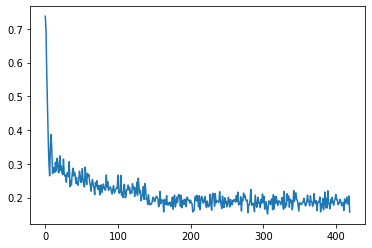

In [38]:
plt.plot(range(len(losses)), losses)

### Validating the net

In [39]:
x_numerical_train, x_categorical_train, y_train = train_ds.reverse_transform()

In [40]:
x_numerical_val, x_categorical_val, y_val = validation_ds.reverse_transform()

In [41]:
x_numerical_test, x_categorical_test, _ = test_ds.reverse_transform()

In [42]:
y_train_pred = model.predict(train_dl_for_prediction).numpy().squeeze()

In [43]:
y_val_pred = model.predict(validation_dl).numpy().squeeze()

In [44]:
y_test_pred = model.predict(test_dl).numpy().squeeze()

#### Training

In [45]:
aucroc_train = roc_auc_score(y_train, y_train_pred)
print(f'Auc Roc in training: {aucroc_train}')

Auc Roc in training: 0.930069730591593


In [46]:
accuracy_train = accuracy_score(y_train, [1 if pred >= .5 else 0 for pred in y_train_pred])
print(f'Accuracy in training: {accuracy_train}')

Accuracy in training: 0.9226112485198394


#### Validation

In [47]:
aucroc_val = roc_auc_score(y_val, y_val_pred)
print(f'Auc Roc in test: {aucroc_val}')

Auc Roc in test: 0.8594174323303001


In [48]:
accuracy_val = accuracy_score(y_val, [1 if pred >= .5 else 0 for pred in y_val_pred])
print(f'Accuracy in test: {accuracy_val}')

Accuracy in test: 0.9029968454258676


#### Testing submission

In [51]:
y_test_pred[:5]

array([0.00653152, 0.00143854, 0.24205764, 0.00068901, 0.26798746],
      dtype=float32)

In [52]:
submission = pd.DataFrame({
    'conversion': y_test_pred
}).reset_index().rename({'index':'ROW_ID'}, axis=1)
submission['conversion'] = np.round(submission['conversion'], 4)
submission.tail()

,ROW_ID,conversion
19206,19206,0.0473
19207,19207,0.0560
19208,19208,0.0039
19209,19209,0.0465
19210,19210,0.0013


In [53]:
submission.to_csv('submissions/submission.csv.gz', compression='gzip', index=False)